# How to choose the best model with kluster.ai - a comparative analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/model-comparison.ipynb)

Welcome to the model comparison notebook powered by the <a href="https://kluster.ai/" target="_blank">kluster.ai</a> Batch API!

kluster.ai offers a range of highly capable models at <a href="https://www.kluster.ai/#pricing" target="_blank">prices</a> that are significantly lower than most of the other providers, making advanced AI more accessible. This cost advantage, paired with high performance, ensures that users can find the right balance between price and capability. While all kluster.ai models excel in various tasks, you may still want to choose the one that best adapts to your specific needs. The goal is to select a model that achieves the expected results while minimizing costs, avoiding unnecessary expenses from higher-priced models when a smaller, more efficient option may suffice. This notebook demonstrates how to compare different models to help you make the most cost-effective and performance-driven choice.

Using the IMDb 1000 Movie dataset, we will request each model to classify the genre of the movies based on their description. With the ground truth, or true labels, of each movie’s genres as originally provided by the dataset, we will calculate the accuracy of each model.

Before diving into model comparisons, it’s important to understand the concept of accuracy and why it’s a key metric for evaluating performance. Accuracy measures how often a model’s classifications match the actual labels, or ground truth, in a dataset. It provides a straightforward indication of how well the model is performing on the given task.

$$ \text{Accuracy} = \frac{\text{Number of Correct Classifications}}{\text{Total Number of Classifications}} $$

To get started, simply provide your API key and run the preloaded cells to perform the model comparisons. If you don’t have an API key, you can sign up for free <a href="https://platform.kluster.ai/signup" target="_blank">on our platform</a>.

## Config

Enter your personal kluster.ai API key. Remember to <a href="https://platform.kluster.ai/signup" target="_blank">sign up</a> if you don't have one yet.

In [1]:
from getpass import getpass
# Enter you personal kluster.ai API key (make sure in advance it has no blank spaces)
api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


## Setup

In [2]:
%pip install -q OpenAI

Note: you may need to restart the kernel to use updated packages.


In [3]:
import urllib.request
import pandas as pd
import numpy as np
from openai import OpenAI
import time
import json
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

In [4]:
# Set up the client
client = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Useful functions

In this section, we define a set of utility functions to streamline predictions with each model.

If you’re unfamiliar with the basics of using the kluster.ai Batch API, please refer to our <a href="https://docs.kluster.ai/tutorials/klusterai-api/getting-started/" target="_blank">introductory notebook</a> for a comprehensive guide.

#### Create the Batch File

Here we’ll create a file containing the requests to be processed by the model.

In [5]:
def create_tasks(df, task_type, system_prompt, model):
    tasks = []
    for index, row in df.iterrows():
        content = row['Overview']
        
        task = {
            "custom_id": f"{task_type}-{index}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": model,
                "temperature": 0,
                "response_format": {"type": "json_object"},
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": content},
                ],
            }
        }
        tasks.append(task)
    return tasks

def save_tasks(tasks, task_type):
    filename = f"batch_tasks_{task_type}.jsonl"
    with open(filename, 'w') as file:
        for task in tasks:
            file.write(json.dumps(task) + '\n')
    return filename

#### Upload Batch File to kluster.ai

Once the file is ready, we’ll upload it to the <a href="https://platform.kluster.ai" target="_blank">kluster.ai platform</a> using the API, where it will be queued for processing.

In [6]:
def create_batch_job(file_name):
    print(f"Creating batch job for {file_name}")
    batch_file = client.files.create(
        file=open(file_name, "rb"),
        purpose="batch"
    )

    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    return batch_job

#### Check Job progress

With this function, we can monitor the status of each job to track its progress.

In [7]:
def parse_json_objects(data_string):
    if isinstance(data_string, bytes):
        data_string = data_string.decode('utf-8')

    json_strings = data_string.strip().split('\n')
    json_objects = []

    for json_str in json_strings:
        try:
            json_obj = json.loads(json_str)
            json_objects.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

    return json_objects

def monitor_job_status(client, job_id, task_type):
    all_completed = False

    while not all_completed:
        all_completed = True
        output_lines = []

        updated_job = client.batches.retrieve(job_id)

        if updated_job.status.lower() != "completed":
            all_completed = False
            completed = updated_job.request_counts.completed
            total = updated_job.request_counts.total
            output_lines.append(f"{task_type.capitalize()} job status: {updated_job.status} - Progress: {completed}/{total}")
        else:
            output_lines.append(f"{task_type.capitalize()} job completed!")

        # Clear the output and display updated status
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        if not all_completed:
            time.sleep(10)

#### Get the results

Finally, this will retreive the results for each of the jobs.

In [8]:
def get_results(client, job_id):
    batch_job = client.batches.retrieve(job.id)
    result_file_id = batch_job.output_file_id
    result = client.files.content(result_file_id).content
    results = parse_json_objects(result)
    answers = []
    
    for res in results:
        task_id = res['custom_id']
        result = res['response']['body']['choices'][0]['message']['content']
        answers.append(result)
    
    return answers

## Fetch the data

With everything configured and our utility functions defined, it’s time to retrieve the dataset for our analysis. For this demonstration, we’ll be using the IMDb Top 1000 dataset, which contains information about top-rated movies, including their descriptions and genres.

In [9]:
# IMDB Top 1000 dataset:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/refs/heads/main/data/imdb_top_1000.csv"
urllib.request.urlretrieve(url,filename='imdb_top_1000.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('imdb_top_1000.csv', usecols=['Series_Title', 'Overview', 'Genre'])
df.head(3)

,Series_Title,Genre,Overview
0,The Shawshank Redemption,Drama,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.
2,The Dark Knight,"Action, Crime, Drama","When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."


As you may notice, each movie already has a predefined label, and in some cases, there may be more than one label for each movie. For the purpose of this notebook, we will ask the model to identify just one genre. If the predicted genre matches at least one of the genres listed in the dataset’s genre column (our ground truth), we will consider the prediction to be correct.

## Batch inference

Now, we define the prompt that will guide the model to perform the classification task. 

In [11]:
SYSTEM_PROMPT = '''
    You are a helpful assitant that classifies movie genres based on the movie description. Choose one of the following options: 
    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.
    Provide your response as a single word with the matching genre. Don't include punctuation.
    '''

Now that the prompt is defined, it’s time to execute the code and run the classification task for each model. In this step, we loop through the list of models, apply the defined prompt, and generate predictions for each movie in the dataset.

In [12]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        '70B_3_1':"klusterai/Meta-Llama-3.1-70B-Instruct-Turbo",
        '70B_3_3':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        '405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model)
    filename = save_tasks(task_list, task_type='assistant')
    job = create_batch_job(filename)
    monitor_job_status(client=client, job_id=job.id, task_type=f'{name} model')
    df[f'{name}_genre'] = get_results(client=client, job_id=job.id)

'405b model job completed!'

## Evaluating the results

To determine which model performs better, we will evaluate their classifications using the accuracy metric. Accuracy measures the proportion of correct classifications compared to the total number of classifications. 

Since each model is instructed to predict only one genre per movie, and some movies have multiple genres, we consider a classification correct if the predicted genre matches any of the ground truth genres provided in the dataset.

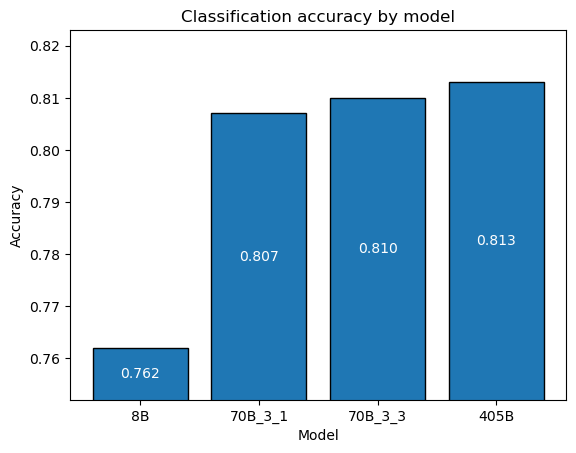

In [13]:
# Calculate accuracy for each model
accuracies = {}
for name, _ in models.items():
    accuracy = df.apply(lambda row: row[f'{name}_genre'] in row['Genre'].split(', '), axis=1).mean()
    accuracies[name] = accuracy

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(accuracies.keys(), accuracies.values(), edgecolor='black')
ax.bar_label(bars, label_type='center', color='white', fmt="%.3f")
ax.set_ylim(min(accuracies.values())-0.01, max(accuracies.values())+ 0.01)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Classification accuracy by model')
plt.show()

Based on the graph, it’s clear that the 405B model is the absolute winner in terms of accuracy. However, the 70B models (both 70B 3.1 and 70B 3.3) also demonstrate excellent performance, achieving nearly the same level of accuracy. Given that the 70B models are significantly more cost-effective (check out the <a href="https://platform.kluster.ai/signup" target="_blank">pricing</a> table), the intelligent choice for this use case would be to select one of the 70B models.